1. Conclusion

The data is a time series format with timestamps and corresponding metric values.
It looks like there are certain regions where the metric deviates from the normal trend. This seems to be anomalies anomalies.
Overall, the metric shows a steady trend with some spikes which might be the anomalies we need to detect.
We canuse anomaly column (anom) as ground truth for training and evaluation.


2. Select a simple Scikit-learn method for detection and motivate the choice.

Given that the data is time-series and we are interested in anomalies, I chose Isolation Forest. This algorithm is particularly suited for anomaly detection in cases where the data has a high dimensionality.

Isolation Forest is efficient for high-dimensional datasets.
It isolates anomalies instead of profiling normal data points.
Suitable for a real time data stream since it has a low computational cost.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

url = "https://storage.googleapis.com/bdt-beam/uni-anom-line.csv"
data = pd.read_csv(url)

# Display the first few rows to check
data.head()

,Unnamed: 0,time,metric,anom
0,0,1980-01-01,1024.00,False
1,1,1980-01-02,1024.01,False
2,2,1980-01-03,1024.02,False
3,3,1980-01-04,1024.03,False
4,4,1980-01-05,1024.24,False


In [ ]:
# Drop the Unnamed: 0 column
data = data.drop(columns=["Unnamed: 0"])

# Convert 'time' column to datetime type
data['time'] = pd.to_datetime(data['time'])

In [ ]:
# Summary statistics
print(data['metric'].describe())

count    10000.000000
mean      1123.931977
std         63.648404
min       1023.850000
25%       1062.987500
50%       1122.875000
75%       1174.842500
max       1242.890000
Name: metric, dtype: float64


<Axes: title={'center': 'Distribution of Anomalies'}>

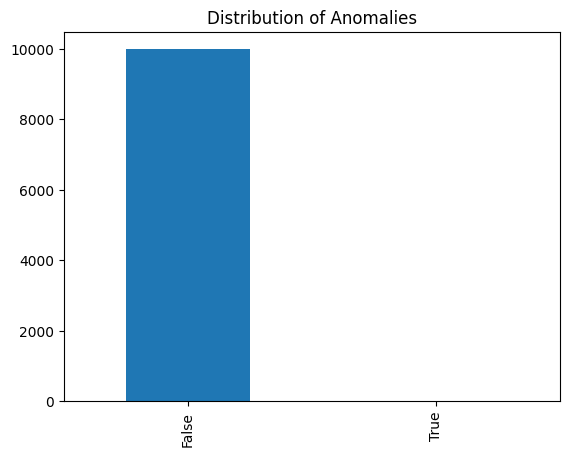

In [ ]:
data['anom'].value_counts().plot(kind='bar', title='Distribution of Anomalies')

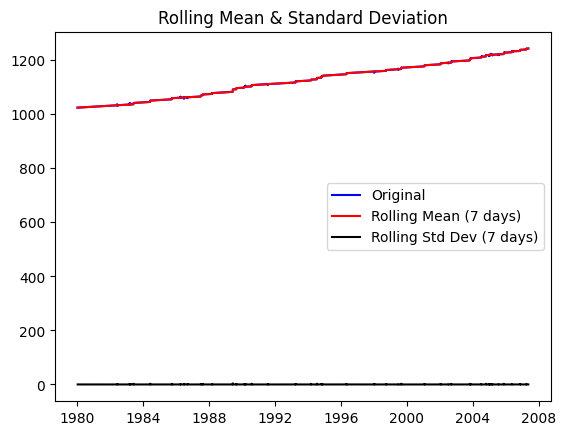

In [ ]:
rolling_mean = data['metric'].rolling(window=7).mean()
rolling_std = data['metric'].rolling(window=7).std()

plt.plot(data['time'], data['metric'], color='blue', label='Original')
plt.plot(data['time'], rolling_mean, color='red', label='Rolling Mean (7 days)')
plt.plot(data['time'], rolling_std, color='black', label='Rolling Std Dev (7 days)')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

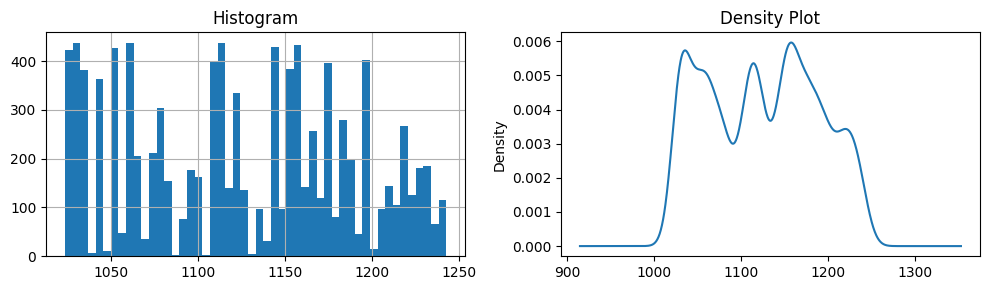

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
data['metric'].hist(bins=50)
plt.title('Histogram')
plt.subplot(1, 2, 2)
data['metric'].plot(kind='kde')
plt.title('Density Plot')
plt.tight_layout()
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

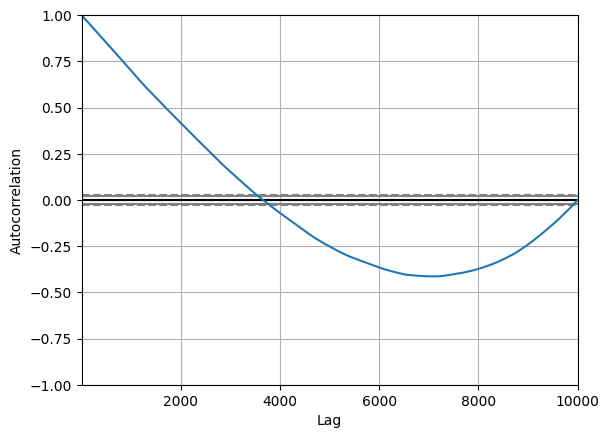

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data['metric'])

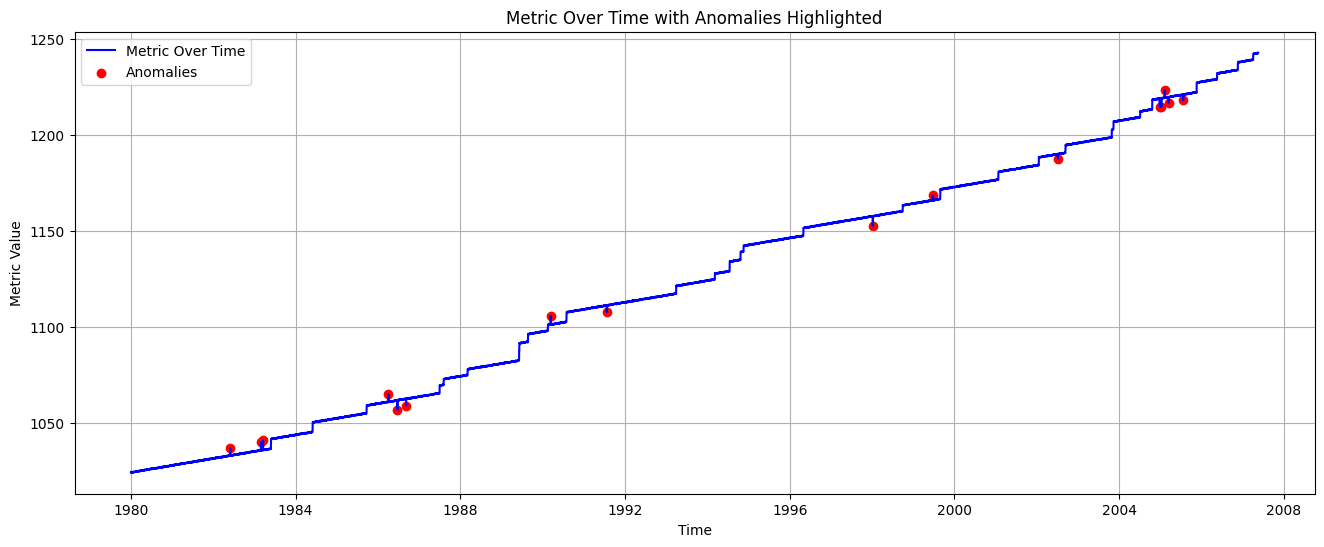

In [ ]:
# Plot the metric over time
plt.figure(figsize=(16, 6))
plt.plot(data['time'], data['metric'], label='Metric Over Time', color='blue')

# Highlight anomalies in red
anomalies = data[data['anom']]
plt.scatter(anomalies['time'], anomalies['metric'], color='red', label='Anomalies')

plt.xlabel('Time')
plt.ylabel('Metric Value')
plt.title('Metric Over Time with Anomalies Highlighted')
plt.legend()
plt.grid(True)
plt.show()

Conclusions/Insights:
The data is in a time-series format with timestamps and corresponding metric values.
Certain regions in the data deviate from the usual trend, possibly representing anomalies.
The anomaly column (anom) can be used as ground truth for training and evaluation.

In [ ]:
# Run and print a shell command.
def run(cmd):
    print('>> {}'.format(cmd))
    get_ipython().system(cmd)
    print('')

run('pip install --upgrade pip')

# Install apache-beam.
run('pip install --quiet apache-beam')

# Copy the input file into the local file system.
run('mkdir -p data')
run('wget https://storage.googleapis.com/bdt-beam/uni-anom-line.csv')

>> pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2

>> pip install --quiet apache-beam
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 33.8 MB/s eta 0:0

In [ ]:
import numpy as np
from sklearn.ensemble import IsolationForest
import apache_beam as beam
import pandas as pd

# 1. Prepare and Train IsolationForest model
data = pd.read_csv("uni-anom-line.csv")
data_metric = np.array(data["metric"]).reshape(-1, 1)
clf = IsolationForest()
clf.fit(data_metric)

# Function to apply the trained model
def detect_anomalies(element):
    metric_value = np.array([element["metric"]]).reshape(-1, 1)
    prediction = clf.predict(metric_value)
    element["pred"] = (prediction == -1)  # Convert -1 and 1 to True and False
    return element

class CollectResults(beam.DoFn):
    def process(self, element):
        global results_list
        results_list.append(element)

results_list = []
with beam.Pipeline() as pipeline:
    _ = (
        pipeline
        | 'ReadData' >> beam.io.ReadFromText('uni-anom-line.csv', skip_header_lines=1)
        | 'ParseCSV' >> beam.Map(lambda line: {"metric": float(line.split(',')[2]), "anom": line.split(',')[3] == 'True'})
        | 'DetectAnomalies' >> beam.Map(detect_anomalies)
        | 'Collect' >> beam.ParDo(CollectResults())
    )

# Compute accuracy post-pipeline
predictions = [x["pred"] for x in results_list]
accuracy = (np.array(predictions) == data["anom"].values).mean()
print("Accuracy:", accuracy)

Accuracy: 0.37829072


In [ ]:
pip install --upgrade apache-beam